In [68]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)

import fnmatch

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import seaborn as sns
import scipy as sp
import scipy.fftpack as fp

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats

from aeon.transformations.collection.dictionary_based import PAA
import scipy.stats as stats

import sys
sys.path.append("../")

In [69]:
path_queries = "queries/"

files_queries = {    
    "LenDB_queries.bin" : [256, np.float32],
    "SCEDC_queries.bin" : [256, np.float32],
    "Meier2019JGR_queries.bin" : [256, np.float32],
    "SIFT1b_queries.bin" : [256, np.float32],
    #"OBS_queries.bin" : [256, np.float32],
    "bigANN_queries.bin" : [100, np.uint8],    
    "Iquique_queries.bin" : [256, np.float32],
    #"astro_queries.bin": [256, np.float32],    
    # "ETHZ_queries.bin" : [256, np.float32],
    #"OBST2024_queries.bin" : [256, np.float32],
    #"ISC_EHB_DepthPhases_queries.bin" : [256, np.float32],
    #"NEIC_queries.bin" : [256, np.float32],
    #"SALD_queries.bin" : [256, np.float32],    
    #"deep1b_queries.bin" : [96, np.float32],    
    #"PNW_queries.bin" : [256, np.float32],


    
    #"SimSearchNet_queries.bin" : [256, np.uint8],
    # "spacev1B_queries.bin" : [100, np.int8],
    #"TEXT_TO_IMAGE_queries.bin" : [200, np.float32],    
     # "turing_ANNS__head2.bin": [100, np.int8],    
    #"turingANNs_queries.bin": [100, np.float32],    
    #"SCEDC_queries.bin" : [256, np.float32],
    #"sift1b_queries.bin" : [128, np.float32],
    #"seismic_queries.bin" : [256, np.float32],
    #"noiseSeismic01.bin" : [256, np.float32],
    }

# "noiseSALD01.bin" : [128, np.float32],
# "noiseSeismic01.bin": [256, np.float32],    


path = "../data_head/"

files = {    
    "GEOFON_queries.bin" : [256, np.float32],
    "ETHZ_queries.bin" : [256, np.float32],
    #"SimSearchNet_head.bin" : [256, np.uint8],
    #"spacev1B_head.bin" : [100, np.int8],
    #"bigANN_head.bin" : [100, np.uint8],
    #"text-to-image_head.bin" : [200, np.float32],    
    #"turingANNs_head.bin": [100, np.int8],    
    #"astro_head.bin": [256, np.float32],
    #"SALD_head.bin" : [256, np.float32],
    #"SCEDC_head.bin" : [256, np.float32],
    #"sift1b_head.bin" : [128, np.float32],
    #"deep1b_head.bin" : [96, np.float32],
    #"seismic_head.bin" : [256, np.float32],
    }


LenDB_queries.bin   	 False
(256,)
SCEDC_queries.bin   	 False
(256,)
Meier2019JGR_queries.bin   	 False
(256,)
SIFT1b_queries.bin   	 False
(256,)
bigANN_queries.bin   	 False
(100,)
Iquique_queries.bin   	 False
(256,)


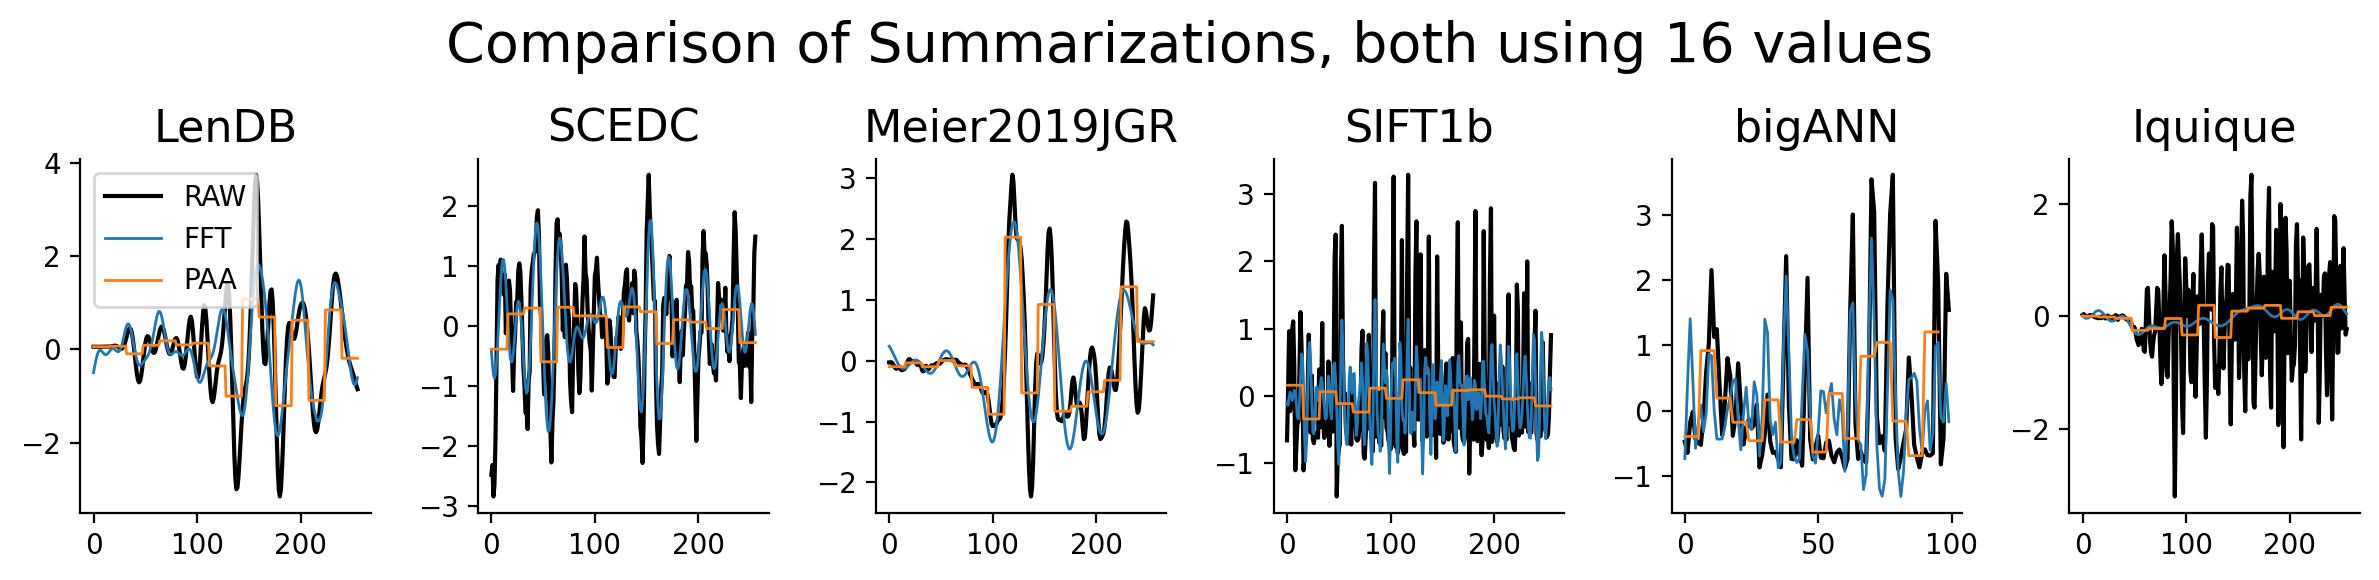

In [91]:
import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)

fig, axes = plt.subplots(int( np.ceil(len(files_queries) / 6)), 6, figsize=(12, 3))

segments = 16
paa = PAA(n_segments=segments)
id = 1

for i, key in enumerate(files_queries):    
    file = path_queries + key
    length, data_type = files_queries[key]
    
    data = np.fromfile(file, dtype=data_type)
    ## data = np.fromfile(file, dtype=np.float32)
    print(key, "  \t", np.isnan(data).any())

    data = (data[:len(data)-len(data)%length].reshape(-1, length)).T
    data = sp.stats.zscore(data, axis = 1)

    paa_data = paa.fit_transform(data.T).squeeze(1)# [:,id]
    paa_data = paa_data[id,:]
    paa_data = np.repeat(paa_data, len(data)/len(paa_data))

    dft_variance = np.var(fp.rfft(data.T), axis=0)# [:64]
    support = np.argsort(-dft_variance)[: segments + 1]
    support = np.sort(support)
    # support = np.arange(segments)
    
    dft = fp.rfft(data[:, id])
    fft = np.zeros(dft.shape[0])
    fft[support] = dft[support]
    fft[0] = dft[0]    
    fft_data = fp.irfft(fft, data.shape[0])
    print(fft_data.shape)
    
    ax = axes.flatten()[i]
    sns.lineplot(data=data[:,id], ax = ax, ls="-", label="RAW", color="black")
    sns.lineplot(data=fft_data, ax = ax, lw=1, label="FFT")
    sns.lineplot(data=paa_data, ax = ax, lw=1, label="PAA")
    sns.despine()
    ax.set_title(key.replace("_queries", "").replace(".bin", "").replace("_", "-"), size=16)
    
    if i >= 1:
        ax.legend([],[], frameon=False)
        # plt.legend(False)

    # print(np.std(data), np.mean(data

# fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison of Summarizations, both using " + str(segments) + " values", y=0.95, size=20)
plt.tight_layout()

plt.savefig("images/data_fft_paa.pdf", bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

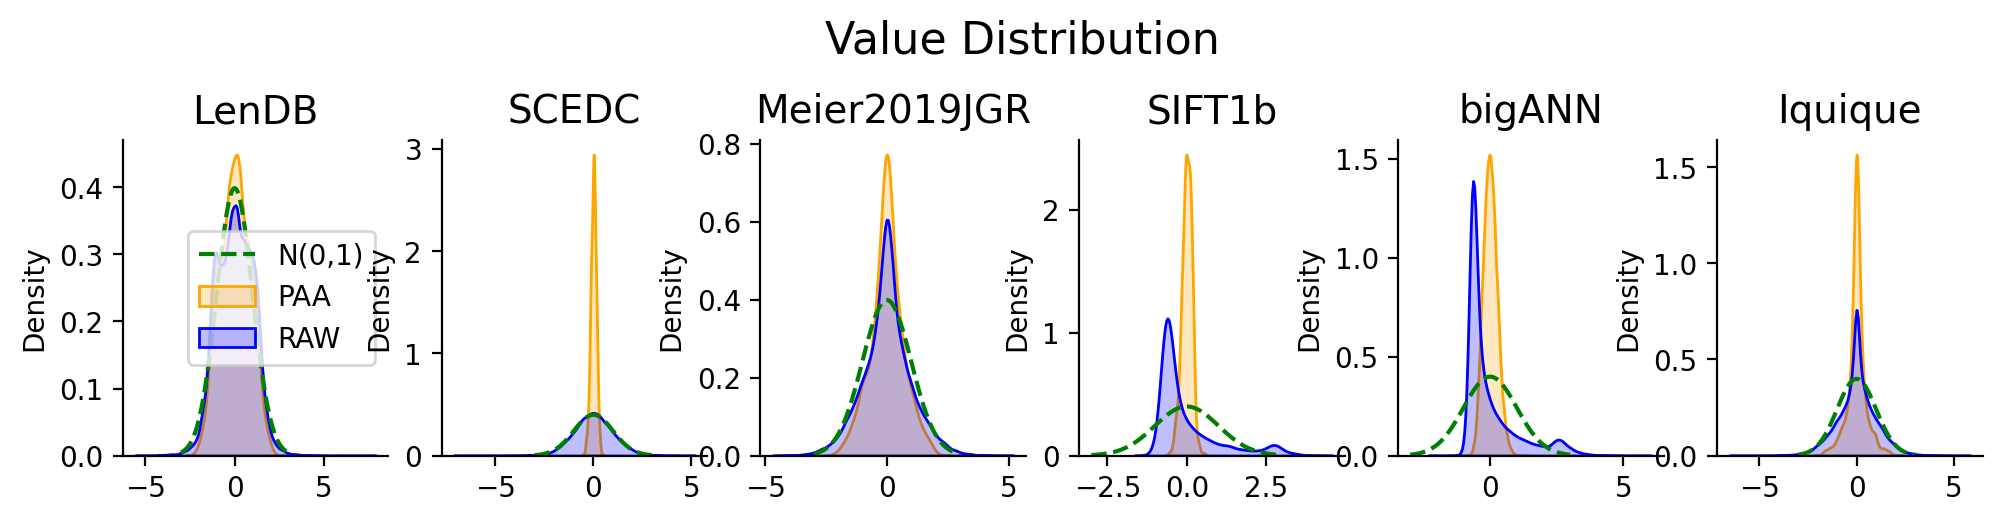

In [89]:


def plot_files(all_files, file_path): 
    paa = PAA(n_segments=8)
    fig, axes = plt.subplots(int( np.ceil(len(files_queries) / 6)), 6, figsize=(12, 2))

    for i, key in enumerate(files_queries.keys()):
        file = path_queries + key
        # print(path_queries, file)
        
        length, data_type = files_queries[key]        
        data = np.fromfile(file, dtype=data_type)
    
        data = (data[:len(data)-len(data)%length].reshape(-1, length))# [:100,:]
        data_normed = sp.stats.zscore(data, axis=1)
                    
        x = np.linspace(0 - 3, 0 + 3, 100)
    
        ax = axes.flatten()[i]
        sns.lineplot(x=x, y=stats.norm.pdf(x, 0, 1), ax=ax, linestyle="--", color="green", label="N(0,1)")

        try : 
            paa_data = paa.fit_transform(data_normed)
            sns.kdeplot(data=paa_data.flatten(), ax = ax, label="PAA", color="orange", common_norm=False, fill=True)
        except:
            print("Error with PAA", key)
            print (data[-1])
            print(key, "  \t", np.isnan(data).any())            
            print(key, "  \t", np.isfinite(data).any())
        
        sns.kdeplot(data=data_normed.flatten(), ax = ax, label="RAW", color="blue", common_norm=False, fill=True)
    
        ax.legend()
        ax.set_title(key.replace("_queries", "").replace(".bin", "").replace("_", "-").replace("-head", ""), size=14)    
        sns.despine()
        if i >=1:
            ax.legend([],[], frameon=False)

    fig.subplots_adjust(top=0.9)
    fig.suptitle("Value Distribution", y=1.20, size=16)
    # print(np.std(data), np.mean(data))
    

plt.tight_layout()
plot_files(files, path)
plt.savefig("images/distribution_data.pdf", bbox_inches='tight')
plt.show()